# Calculate SWE at Watershed Scale:

In [154]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import altair as alt
import geopandas as gpd
import pickle
import rasterio as rio
import altair as alt
import pickle

In [98]:
station_clusters = pickle.load(open('../data/combined_snotel_cdec/station_clusters.pkl', 'rb'))

In [157]:
snv_gdf = pickle.load(open('../data/snv_dataframes/snv_temp_precip_gdf.pkl', 'rb'))

In [40]:
riogrande = rxr.open_rasterio('../data/aso_lidar/riogrande_lidar/ASO_50M_SWE_USCORG_20150407.tif', mask_and_scale=True).squeeze()

In [14]:
clusters = gpd.read_file('../data/cluster_polygons.geojson')

In [3]:
riogrande.rio.crs

CRS.from_epsg(32613)

In [17]:
clusters

date  cluster                                           geometry
0     2017      0.0  POLYGON ((-109.88840 32.67118, -109.88840 32.7...
1     2017      0.0  POLYGON ((-108.60836 33.24006, -108.60836 33.2...
2     2017      0.0  POLYGON ((-108.71503 33.24006, -108.71503 33.3...
3     2017      0.0  POLYGON ((-105.83493 33.34673, -105.83493 33.4...
4     2017      0.0  POLYGON ((-109.39060 33.56006, -109.39060 33.5...
...    ...      ...                                                ...
3123  2017      2.0  POLYGON ((-115.47080 48.49334, -115.47080 48.5...
3124  2017      4.0  POLYGON ((-114.97300 48.49334, -114.97300 48.5...
3125  2017      4.0  POLYGON ((-115.04412 48.95556, -115.04412 48.9...
3126  2017      2.0  POLYGON ((-114.68855 43.58669, -114.68855 43.6...
3127  2017      2.0  POLYGON ((-111.55956 48.95556, -111.55956 48.9...

[3128 rows x 3 columns]

Steps for watershed scale analysis:  
* start with Rio Grande or Conejos in 2016
* ~~Create polygon from raster~~
* clip reanalysis to raster extent
* calculate mean and stdev at each grid cell in the polygon  
* pull mean snv from within-watershed snotel
* calculate swe for each grid cell
* difference with the swe reanalysis data from april 1, 2016
* reproject and scale the 2016 aso data to match reanalysis (how do I make the grid cells align? reproject match?)
* difference from the aso data
* calculate metrics and plot difference maps

### Start with Conejos:

In [99]:
from matplotlib.colors import LinearSegmentedColormap
colors1=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'] #,'#ffff33'
cmap1 = LinearSegmentedColormap.from_list('clusters', colors1)
colors2=['#ff7f00','#4daf4a','#e41a1c','#984ea3','#377eb8'] #,'#ffff33'
cmap2 = LinearSegmentedColormap.from_list('clusters', colors2)

In [38]:
conejos = rxr.open_rasterio('../data/aso_lidar/conejos_lidar/ASO_50M_SWE_USCOCJ_20160403.tif', mask_and_scale=True).squeeze()

In [32]:
conejos.rio.crs

CRS.from_epsg(32613)

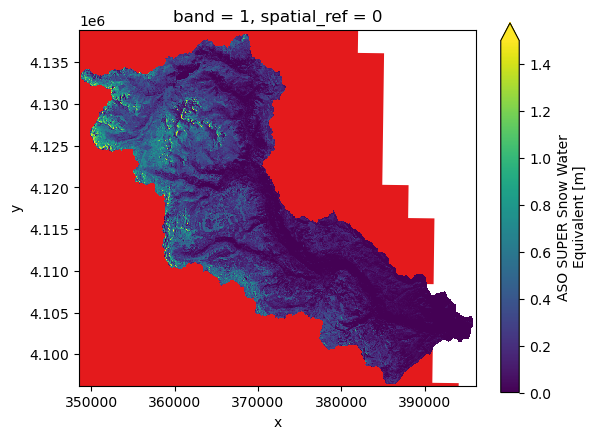

In [29]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
conejos.plot(ax=ax, vmin=0,vmax=1.5)

### Clip SWE Reanalysis to Conejos basin:

In [112]:
conejos_poly = gpd.read_file('../data/misc/conejos_outline.geojson')

In [180]:
conejos_poly.to_crs('epsg:4326').bounds

minx       miny        maxx      maxy
0 -106.707355  37.006934 -106.171561  37.38366

In [111]:
ds = xr.open_dataset('../data/reanalysis/SWE_reanalysis_32yrs.nc')

In [ ]:
conejos_poly.to_crs('epsg:4326')

In [113]:
conejos_poly.to_crs('epsg:4326').geometry

0    POLYGON ((-106.48758 37.38361, -106.48756 37.3...
Name: geometry, dtype: geometry

In [114]:
ds.rio.clip(conejos_poly.to_crs('epsg:4326').geometry)

<xarray.Dataset>
Dimensions:      (y: 84, x: 120, Year: 32)
Coordinates:
  * y            (y) float64 37.01 37.02 37.02 37.02 ... 37.37 37.37 37.38 37.38
  * x            (x) float64 -106.7 -106.7 -106.7 ... -106.2 -106.2 -106.2
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
    spatial_ref  int64 0
Data variables:
    SWE_Post     (Year, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [158]:
snv_gdf.head(2)

station_n  reanalysis_n  elevation_m  station_swe  \
station     year                                                      
301_CA_SNTL 1990  -0.492262     -0.194751  1886.712036      0.19304   
            1991  -0.806681      0.193222  1886.712036      0.14224   

                  station_swe_mean  reanalysis_swe  deg_days_0C  \
station     year                                                  
301_CA_SNTL 1990          0.272574          0.1718         57.0   
            1991          0.272574          0.2416         47.0   

                  cold_deg_days  cumulative_precip_m  precip_mean  ...  \
station     year                                                   ...   
301_CA_SNTL 1990            0.0             0.223842     0.332045  ...   
            1991            0.0             0.237158     0.332045  ...   

                  log_reanalysis_swe_mean  log_precip_std  \
station     year                                            
301_CA_SNTL 1990                     -inf        0.319384   
            1991                     -inf        0.319384   

                  log_station_swe_std  log_reanalysis_swe_std  log_precip_n  \
station     year                                                              
301_CA_SNTL 1990                  NaN                     NaN     -1.079449   
            1991                  NaN                     NaN     -0.898522   

                  log_station_n  log_reanalysis_n   latitude   longitude  \
station     year                                                           
301_CA_SNTL 1990            NaN               NaN  41.235828 -120.791924   
            1991            NaN               NaN  41.235828 -120.791924   

                                     geometry  
station     year                               
301_CA_SNTL 1990  POINT (-120.79192 41.23583)  
            1991  POINT (-120.79192 41.23583)  

[2 rows x 27 columns]

In [159]:
snv_gdf.loc[pd.IndexSlice['580_CO_SNTL', 2016],'station_n']

-0.5948984587765257

In [115]:
ds_conejos = ds.rio.clip(conejos_poly.to_crs('epsg:4326').geometry)

<Axes: title={'center': 'Year = 2016, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

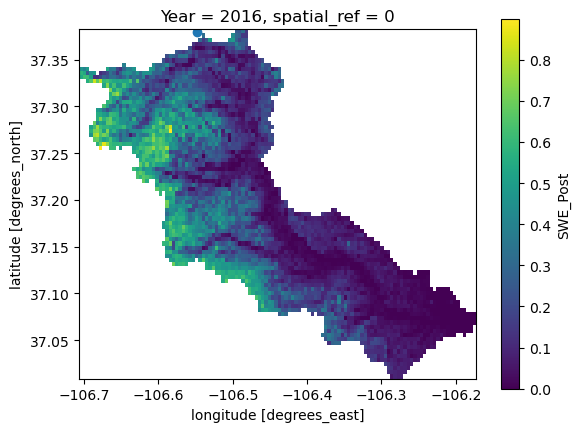

In [151]:
fig, ax = plt.subplots()
ds_conejos.SWE_Post[26].plot(ax=ax)
station_clusters[station_clusters['code']  == '580_CO_SNTL'].plot(ax=ax)

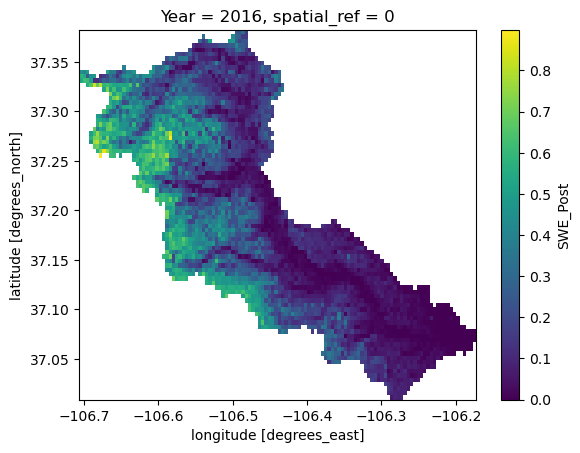

In [120]:
ds_conejos.SWE_Post[26].plot()

In [135]:
conejos_match = conejos.rio.reproject_match(ds_conejos, resampling = rio.enums.Resampling.cubic)

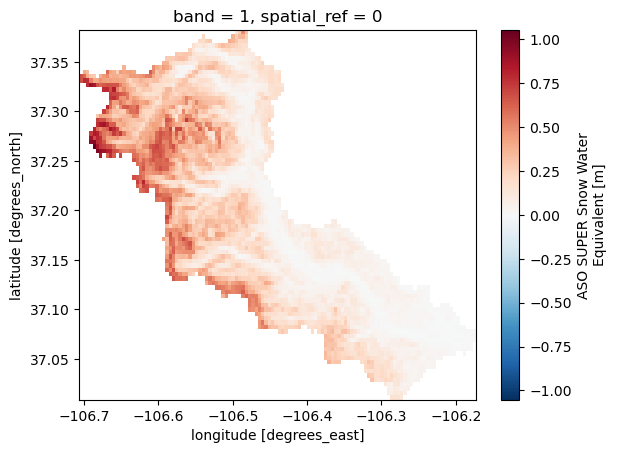

In [137]:
conejos_match.plot()

In [141]:
conejos_dif = ds_conejos.SWE_Post[26] - conejos_match

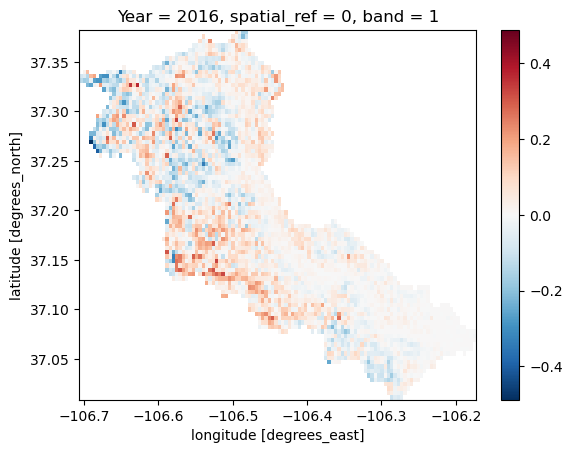

In [142]:
conejos_dif.plot()

In [143]:
ds_conejos.SWE_Post[26].mean()

<xarray.DataArray 'SWE_Post' ()>
array(0.20753382, dtype=float32)
Coordinates:
    Year         int64 2016
    spatial_ref  int64 0

In [144]:
conejos_match.mean()

<xarray.DataArray ()>
array(0.20083515, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [132]:
ds_conejos.rio.reproject_match?

Signature:
ds_conejos.rio.reproject_match(
    match_data_array: Union[xarray.core.dataarray.DataArray, xarray.core.dataset.Dataset],
    resampling: rasterio.enums.Resampling = <Resampling.nearest: 0>,
    **reproject_kwargs,
) -> xarray.core.dataset.Dataset
Docstring:
Reproject a Dataset object to match the resolution, projection,
and region of another DataArray.

.. note:: Only 2D/3D arrays with dimensions 'x'/'y' are currently supported.
    Others are appended as is.
    Requires either a grid mapping variable with 'spatial_ref' or
    a 'crs' attribute to be set containing a valid CRS.
    If using a WKT (e.g. from spatiareference.org), make sure it is an OGC WKT.

.. versionadded:: 0.9 reproject_kwargs

Parameters
----------
match_data_array: :obj:`xarray.DataArray` | :obj:`xarray.Dataset`
    Dataset with the target resolution and projection.
resampling: rasterio.enums.Resampling, optional
    See :func:`rasterio.warp.reproject` for more details.
**reproject_kwargs:
    Other o

#### Find the closest snotel station:

In [147]:
station_clusters.head()

name network  elevation_m  \
code                                                
301_CA_SNTL         Adin Mtn  SNOTEL  1886.712036   
302_OR_SNTL  Aneroid Lake #2  SNOTEL  2255.520020   
303_CO_SNTL         Apishapa  SNOTEL  3048.000000   
304_OR_SNTL     Arbuckle Mtn  SNOTEL  1758.696045   
306_ID_SNTL   Atlanta Summit  SNOTEL  2310.384033   

                                             geometry cluster_anom  
code                                                                
301_CA_SNTL  POINT Z (-120.79192 41.23583 1886.71204)            3  
302_OR_SNTL  POINT Z (-117.19258 45.21328 2255.52002)            0  
303_CO_SNTL  POINT Z (-105.06749 37.33062 3048.00000)            2  
304_OR_SNTL  POINT Z (-119.25392 45.19085 1758.69604)            0  
306_ID_SNTL  POINT Z (-115.23907 43.75690 2310.38403)            3

In [148]:
station_clusters['code'] = station_clusters.index

In [149]:
chart = alt.Chart(station_clusters).mark_geoshape().encode(
    # longitude='geometry.x:Q',
    # latitude='geometry.y:Q',
    color='cluster_anom',
    tooltip='code'
).project(
    "albersUsa"
).properties(
    width=800,
    height=600
)

alt.Chart(...)

### Calculate basin SWE:

In [160]:
conejos_mean = ds_conejos.SWE_Post.mean(dim='Year').where(ds.SWE_Post.mean(dim='Year')>0.1)

In [161]:
conejos_std = ds_conejos.SWE_Post.std(dim='Year', skipna=True, ddof=1).where(ds.SWE_Post.mean(dim='Year')>0.1)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [162]:
conejos_swe_calc = snv_gdf.loc[pd.IndexSlice['580_CO_SNTL', 2016],'station_n'] * conejos_std + conejos_mean

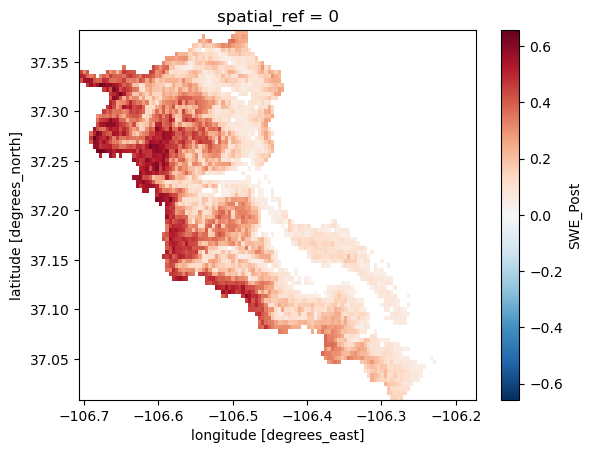

In [163]:
conejos_swe_calc.plot()

In [164]:
conejos_dif_calc = conejos_match - conejos_swe_calc

In [177]:
conejos_dif_calc_re = ds_conejos.SWE_Post[26] - conejos_swe_calc

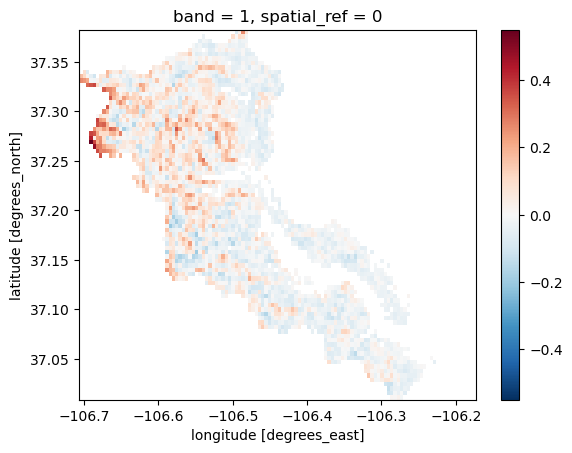

In [165]:
conejos_dif_calc.plot()

Text(0.5, 1.0, 'Difference between SNV-Calculated and ASO')

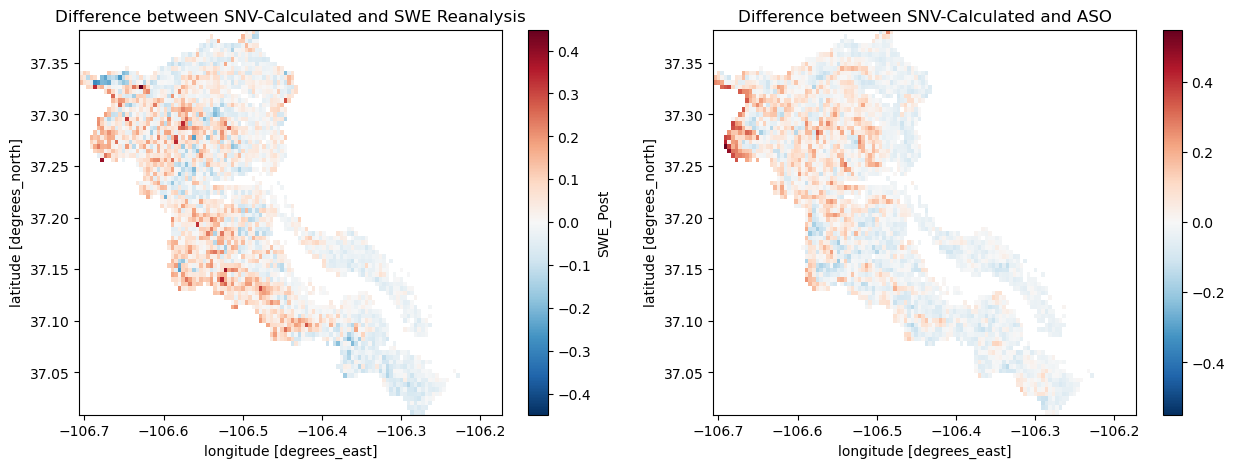

In [178]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
conejos_dif_calc_re.plot(ax=ax[0])
conejos_dif_calc.plot(ax=ax[1])
ax[0].set_title('Difference between SNV-Calculated and SWE Reanalysis')
ax[1].set_title('Difference between SNV-Calculated and ASO')

In [166]:
conejos_dif_calc.mean()

<xarray.DataArray ()>
array(0.00966914, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [179]:
conejos_dif_calc_re.mean()

<xarray.DataArray 'SWE_Post' ()>
array(0.01756813, dtype=float32)
Coordinates:
    Year         int64 2016
    spatial_ref  int64 0

In [167]:
conejos_match.sum()

<xarray.DataArray ()>
array(751.1235, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [168]:
conejos_swe_calc.sum()

<xarray.DataArray 'SWE_Post' ()>
array(711.8024, dtype=float32)
Coordinates:
    spatial_ref  int64 0

In [169]:
conejos_match.sum() - conejos_swe_calc.sum()

<xarray.DataArray ()>
array(39.321045, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

### Plot ASO basins in Colorado:

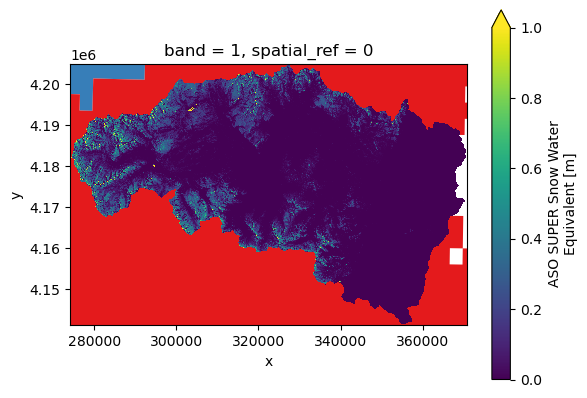

In [108]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
riogrande.plot(ax=ax, vmin=0,vmax=1)


(4100000.0, 4210000.0)

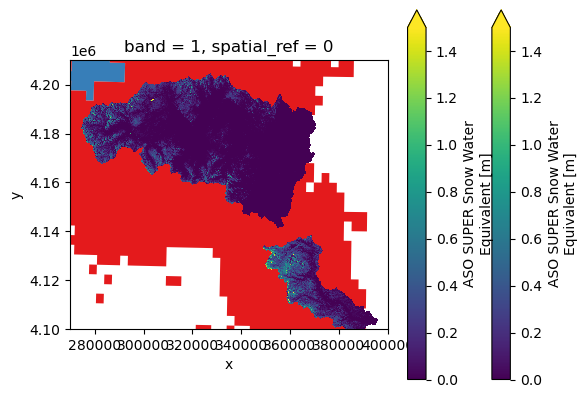

In [42]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
riogrande.plot(ax=ax, vmin=0,vmax=1.5)
conejos.plot(ax=ax, vmin=0,vmax=1.5)

ax.set_xlim(270000, 400000)
ax.set_ylim(4100000, 4210000)

In [44]:
crested_butte = rxr.open_rasterio('../data/aso_lidar/crested_butte_lidar/ASO_50M_SWE_USCOCB_20160404.tif', mask_and_scale=True).squeeze()

In [45]:
crested_butte.rio.crs

CRS.from_epsg(32613)

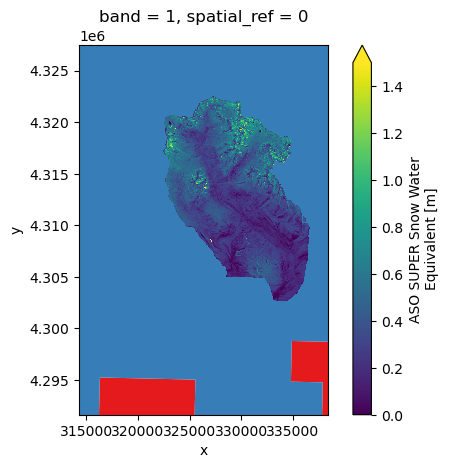

In [46]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
crested_butte.plot(ax=ax, vmin=0,vmax=1.5)
# riogrande.plot(ax=ax, vmin=0,vmax=1.5)
# conejos.plot(ax=ax, vmin=0,vmax=1.5)

# ax.set_xlim(270000, 400000)
# ax.set_ylim(4100000, 4210000)

(4100000.0, 4330000.0)

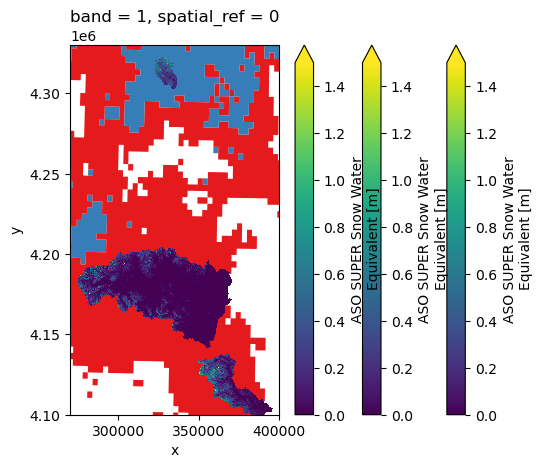

In [47]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
crested_butte.plot(ax=ax, vmin=0,vmax=1.5)
riogrande.plot(ax=ax, vmin=0,vmax=1.5)
conejos.plot(ax=ax, vmin=0,vmax=1.5)

ax.set_xlim(270000, 400000)
ax.set_ylim(4100000, 4330000)

In [49]:
east_river = rxr.open_rasterio('../data/aso_lidar/east_river_lidar/ASO_50M_SWE_USCOGE_20190407.tif', mask_and_scale=True).squeeze()

In [50]:
east_river.rio.crs

CRS.from_epsg(32613)

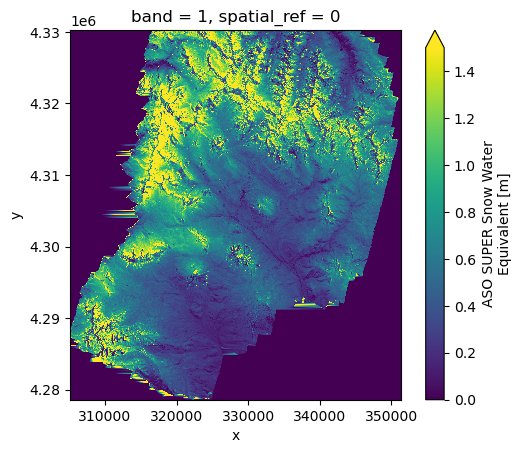

In [51]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
east_river.plot(ax=ax, vmin=0,vmax=1.5)

(4100000.0, 4330000.0)

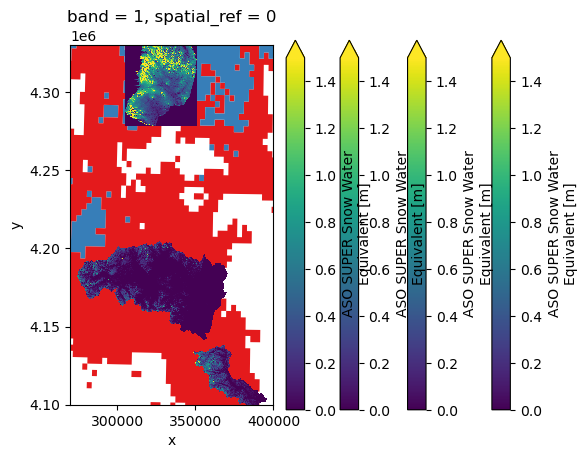

In [53]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
crested_butte.plot(ax=ax, vmin=0,vmax=1.5)
riogrande.plot(ax=ax, vmin=0,vmax=1.5)
conejos.plot(ax=ax, vmin=0,vmax=1.5)
east_river.plot(ax=ax, vmin=0,vmax=1.5)

ax.set_xlim(270000, 400000)
ax.set_ylim(4100000, 4330000)

In [54]:
taylor_river = rxr.open_rasterio('../data/aso_lidar/taylor_river_lidar/ASO_50M_SWE_USCOGT_20180330.tif', mask_and_scale=True).squeeze()

In [55]:
taylor_river.rio.crs

CRS.from_epsg(32613)

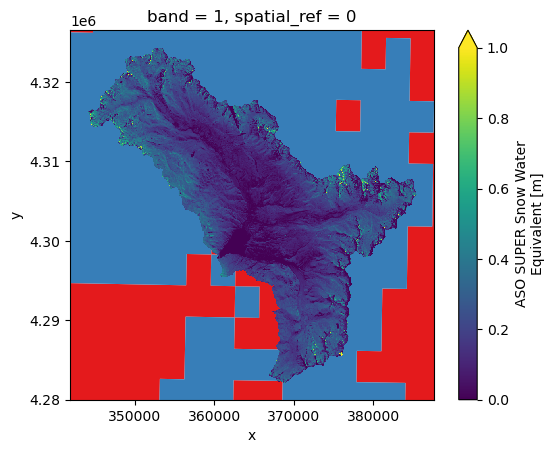

In [95]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
taylor_river.plot(ax=ax, vmin=0,vmax=1)

In [66]:
unc = rxr.open_rasterio('../data/aso_lidar/uncompaghre_lidar/ASO_50M_SWE_USCOUB_20140320.tif', mask_and_scale=True).squeeze()

In [77]:
unc.rio.write_crs('epsg:32613')

<xarray.DataArray (y: 698, x: 700)>
[488600 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 2.397e+05 2.398e+05 ... 2.746e+05 2.747e+05
  * y            (y) float64 4.232e+06 4.232e+06 ... 4.197e+06 4.197e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:        Area
    TIFFTAG_XRESOLUTION:  1
    TIFFTAG_YRESOLUTION:  1

(4000000.0, 5000000.0)

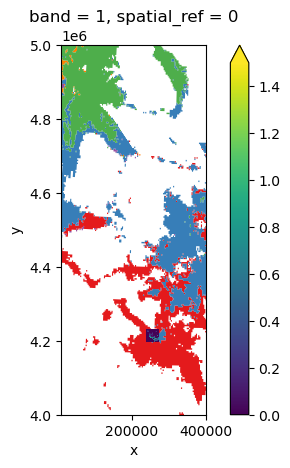

In [81]:
fig, ax = plt.subplots()

clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
unc.rio.write_crs('epsg:32613').plot(ax=ax, vmin=0,vmax=1.5)
ax.set_xlim(10000, 400000)
ax.set_ylim(4000000,5000000)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

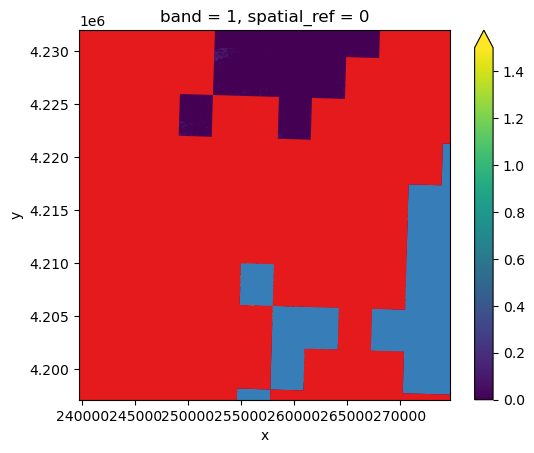

In [86]:
fig, ax = plt.subplots()
unc.rio.write_crs('epsg:32613').plot(ax=ax, vmin=0,vmax=1.5)
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))


In [67]:
aspen = rxr.open_rasterio('../data/aso_lidar/aspen_lidar/ASO_50M_SWE_USCOCM_20190407.tif', mask_and_scale=True).squeeze()

In [69]:
aspen.rio.crs

CRS.from_epsg(32613)

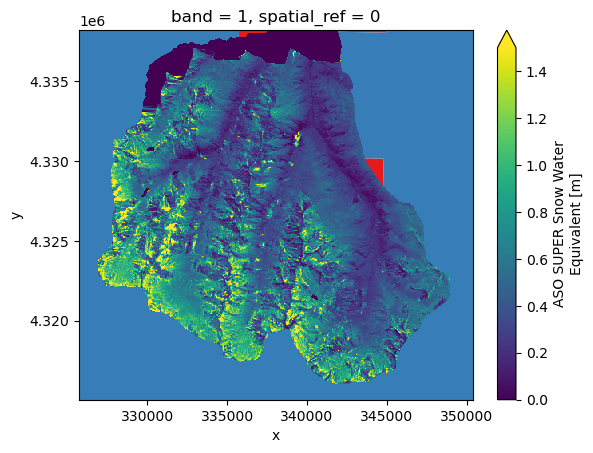

In [107]:
fig, ax = plt.subplots()

clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
aspen.plot(ax=ax, vmin=0,vmax=1.5)

(4100000.0, 4500000.0)

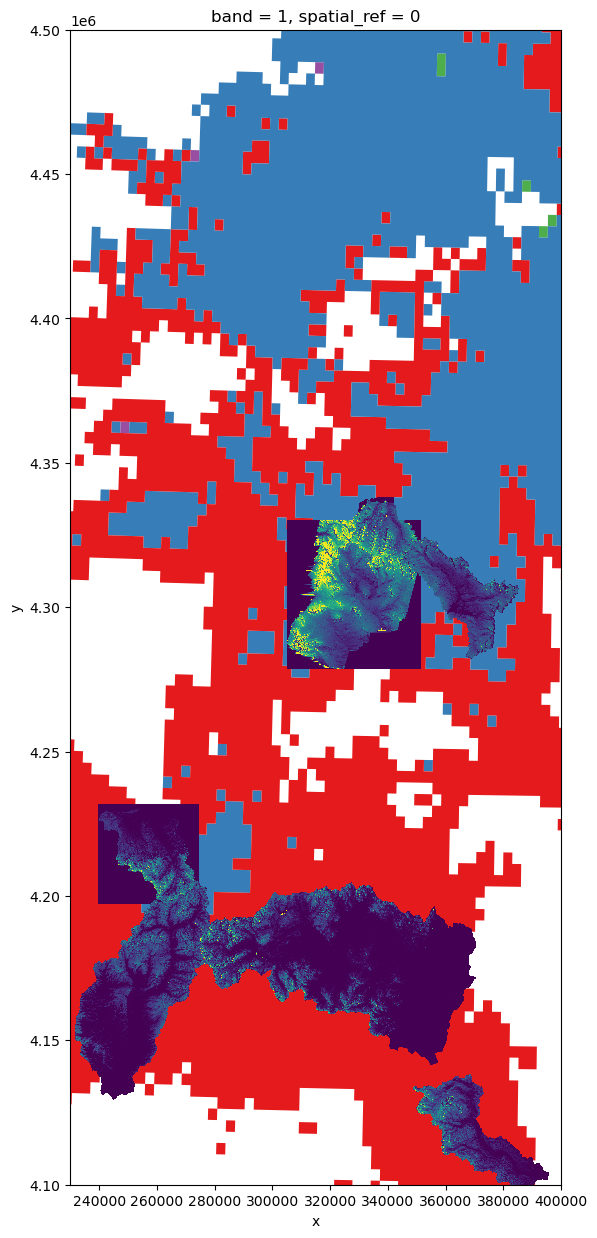

In [109]:
fig, ax = plt.subplots(figsize=(15,15))
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
riogrande.plot(ax=ax, vmin=0,vmax=1, add_colorbar=False)
conejos.plot(ax=ax, vmin=0,vmax=1.5, add_colorbar=False)
east_river.plot(ax=ax, vmin=0,vmax=1.5, add_colorbar=False)
taylor_river.plot(ax=ax, vmin=0,vmax=1, add_colorbar=False)
crested_butte.plot(ax=ax, vmin=0,vmax=1.5, add_colorbar=False)
aspen.plot(ax=ax, vmin=0,vmax=1.5, add_colorbar=False)
unc.rio.write_crs('epsg:32613').plot(ax=ax, vmin=0,vmax=1.5, add_colorbar=False)
animas.plot(ax=ax, vmin=0,vmax=1.5, add_colorbar=False)

ax.set_xlim(230000, 400000)
ax.set_ylim(4100000, 4500000)

In [89]:
animas = rxr.open_rasterio('../data/aso_lidar/animas_lidar/ASO_Animas_Mosaic_2021Apr19_swe_50m.tif', mask_and_scale=True).squeeze()

In [90]:
animas.rio.crs

CRS.from_epsg(32613)

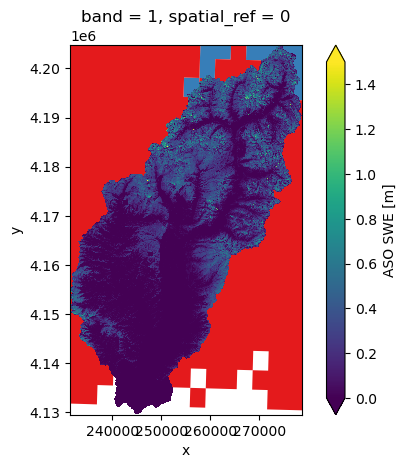

In [92]:
fig, ax = plt.subplots()

clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
animas.plot(ax=ax, vmin=0,vmax=1.5)

In [102]:
station_clusters.head(2)

name network  elevation_m  \
code                                                
301_CA_SNTL         Adin Mtn  SNOTEL  1886.712036   
302_OR_SNTL  Aneroid Lake #2  SNOTEL  2255.520020   

                                             geometry cluster_anom  
code                                                                
301_CA_SNTL  POINT Z (-120.79192 41.23583 1886.71204)            3  
302_OR_SNTL  POINT Z (-117.19258 45.21328 2255.52002)            0

(4100000.0, 4500000.0)

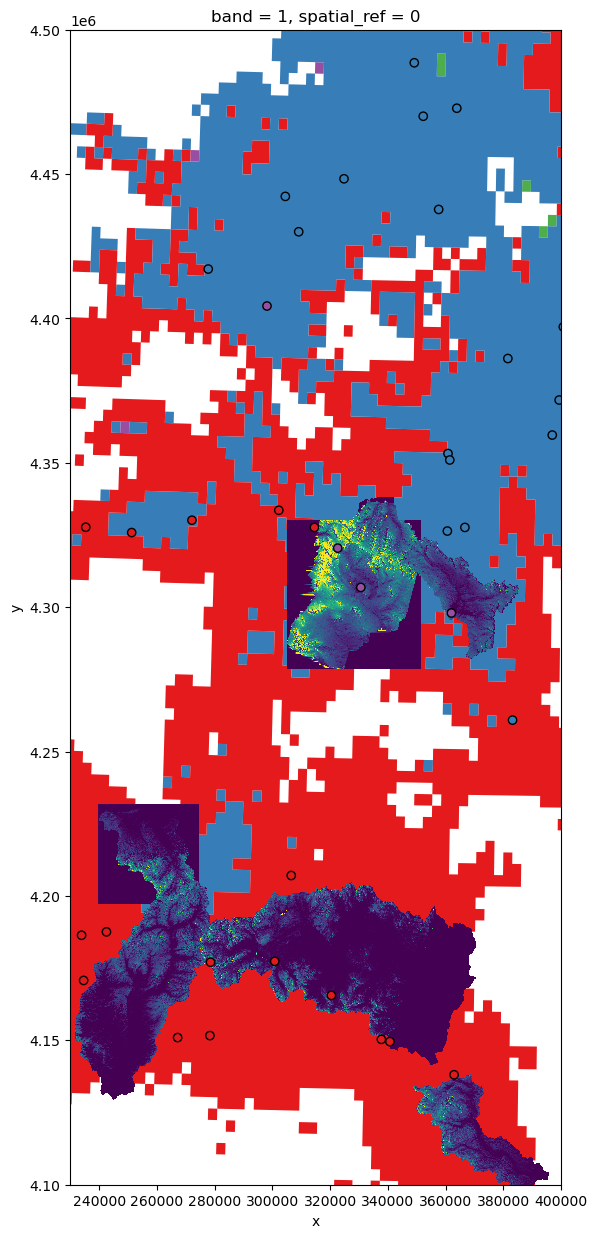

In [110]:
fig, ax = plt.subplots(figsize=(15,15))
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
riogrande.plot(ax=ax, vmin=0,vmax=1, add_colorbar=False)
conejos.plot(ax=ax, vmin=0,vmax=1.5, add_colorbar=False)
east_river.plot(ax=ax, vmin=0,vmax=1.5, add_colorbar=False)
taylor_river.plot(ax=ax, vmin=0,vmax=1, add_colorbar=False)
crested_butte.plot(ax=ax, vmin=0,vmax=1.5, add_colorbar=False)
station_clusters.to_crs('epsg:32613').plot(ax=ax, column='cluster_anom', edgecolor='k', cmap=cmap2)
aspen.plot(ax=ax, vmin=0,vmax=1.5, add_colorbar=False)
unc.rio.write_crs('epsg:32613').plot(ax=ax, vmin=0,vmax=1.5, add_colorbar=False)
animas.plot(ax=ax, vmin=0,vmax=1.5, add_colorbar=False)

ax.set_xlim(230000, 400000)
ax.set_ylim(4100000, 4500000)